# **Multiple Object Tracking with PyTorch**



---
**Reference**


*   Object Detection with Faster R-CNN: https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/ 
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking: https://arxiv.org/abs/1602.00763


**Question**
: What is Multiple Object Tracking?
- Object tracking is one of the tasks in computer vision, which is detecting an object and searching for that object in a video or a series of images (actually both meaning the same thing). 
- Surveillance cameras in public places for spotting suspicious activities or crimes, and a computer system called 'Hawk-eye' for tracking the trajectory of the ball in various sports are typical examples of applying object tracking in a real life.


**Goals**


1. We will use MOT17Det Dataset
2. First part: Object Detection with **Faster R-CNN**
3. Second part: Multiple Object(ID) Tracking with  **Simple Online and Realtime Tracking (SORT)** algorithm



---




**0. Preparation**


*   For your convenience, it is recommended to mount your Google Drive first.
*   Then create extra space for this tutorial in there.


---






In [ ]:
from google.colab import drive
root = '/content/drive/'
drive.mount(root)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Making Directory

import os 
from os.path import join

mot = "My Drive/Colab Notebooks/MOT/"   # a custom path. you can change if you want to
MOT_PATH = join(root,mot)
!mkdir "{MOT_PATH}"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/MOT/’: File exists




---


**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   We will only use MOT17-09 dataset for our task.


---






In [ ]:
y# Download MOT17Det Dataset

!wget -P "{MOT_PATH}" https://motchallenge.net/data/MOT17Det1.zip
!cd "{MOT_PATH}";unzip MOT17Det1.zip

--2021-04-26 09:52:38--  https://motchallenge.net/data/MOT17Det.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1952547113 (1.8G) [application/zip]
Saving to: ‘/content/drive/My Drive/Colab Notebooks/MOT/MOT17Det.zip.1’

MOT17Det.zip.1      100%[===================>]   1.82G  17.7MB/s    in 1m 59s  

2021-04-26 09:54:37 (15.7 MB/s) - ‘/content/drive/My Drive/Colab Notebooks/MOT/MOT17Det.zip.1’ saved [1952547113/1952547113]

Archive:  MOT17Det.zip
  inflating: test/MOT17-01/seqinfo.ini  
  inflating: test/MOT17-03/seqinfo.ini  
  inflating: test/MOT17-06/seqinfo.ini  
  inflating: test/MOT17-07/seqinfo.ini  
  inflating: test/MOT17-08/seqinfo.ini  
  inflating: test/MOT17-12/seqinfo.ini  
  inflating: test/MOT17-14/seqinfo.ini  
  inflating: train/MOT17-02/seqinfo.ini  
  inflating: train/MOT17-04/seqinfo.ini  
 

In [ ]:
# Remove unwanted data for drive volume issue (optional)

!cd "{MOT_PATH}";rm -rf test
!cd "{MOT_PATH}";rm -rf train/MOT17-02;rm -rf train/MOT17-04;rm -rf train/MOT17-05
!cd "{MOT_PATH}";rm -rf train/MOT17-10;rm -rf train/MOT17-11;rm -rf train/MOT17-13

In [ ]:
import sys

motdata = join(MOT_PATH,'train/MOT17-09/img1/')
sys.path.append(motdata)

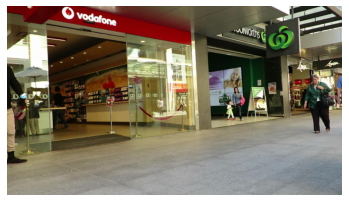

In [ ]:
# Example: Original picture before detection

import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.





---




In [ ]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [ ]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

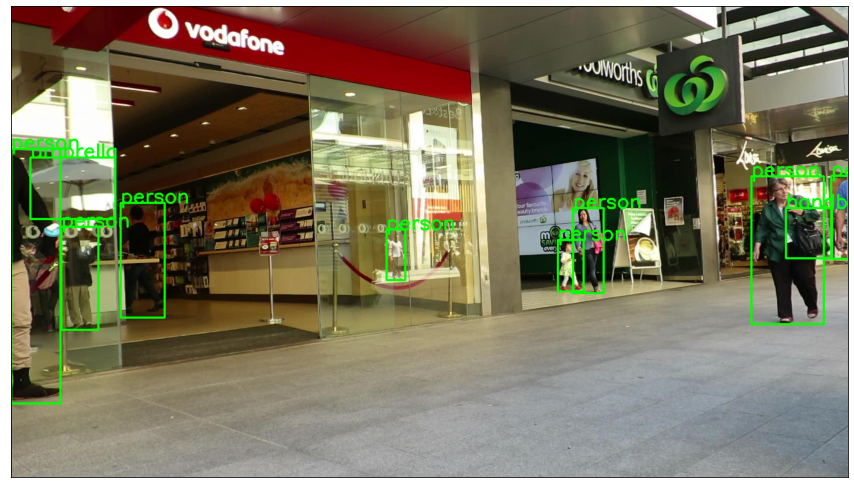

In [ ]:
# Example: After detection
object_detection_api(img_ex_path,threshold=0.8)





*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.






---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [ ]:
# Git clone: SORT Algorithm

!cd "{MOT_PATH}";git clone https://github.com/abewley/sort.git
  
sort = join(MOT_PATH,'sort/')
sys.path.append(sort)

fatal: destination path 'sort' already exists and is not an empty directory.


In [ ]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 184kB 6.8MB/s 
     |████████████████████████████████| 12.5MB 251kB/s 
     |████████████████████████████████| 1.5MB 41.4MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp37-none-any.whl size=110452 sha256=35dff71a0d05422059f024a41cba03beba66775187c5b2bbfc052bed87cd41a8
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590140 sha256=69a8241f943fa163fc49bef5d5f1984e9cc96d524e54dca2735171031eddf926
  Stored in directory: /root/.cache/pip/wheels/da/3e/af/eddcd6ffaa27df8d0ddac573758f8953c4e57c64c4c8c8b7d0
Successfully built filterpy lap
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [ ]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image
!pip uninstall imgaug
!pip install imgaug
!pip install -U scikit-image

import skimage
print(skimage.__version__)

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/uninstall.py", line 79, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_install.py", line 755, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 388, in remove
    if auto_confirm or self._allowed_to_proceed(verbose):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/req/req_uninstall.py", line 431, in _allowed_to_proceed
    return ask('Proceed (y/n)? ', ('y', 'n')) == 'y'
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/utils/misc.py", line 245, in ask
    response = input(message)
KeyboardInterrupt

In [ ]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!cd "{MOT_PATH}";git clone https://github.com/mlvlab/COSE474.git

fatal: destination path 'COSE474' already exists and is not an empty directory.


In [ ]:
import json
import collections
from pprint import pprint
import matplotlib
matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from sort import *

jsonpath = join(MOT_PATH,'COSE474/3_MOT_detinfo.json')

with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

In [ ]:
# Let's check out downloaded json file

pprint(odata)

Streaming output truncated to the last 5000 lines.
                'scores': 0.9063880443572998},
               {'bbox': [34.13352966308594,
                         355.93682861328125,
                         85.53865051269531,
                         401.1189270019531],
                'labels': 68,
                'scores': 0.8869121670722961},
               {'bbox': [1317.8665771484375,
                         566.4204711914062,
                         1369.163818359375,
                         642.6348266601562],
                'labels': 27,
                'scores': 0.8799705505371094},
               {'bbox': [1227.9986572265625,
                         579.244873046875,
                         1272.51025390625,
                         648.2922973632812],
                'labels': 27,
                'scores': 0.7431402206420898}]),
             ('000459.jpg',
              [{'bbox': [76.42948150634766,
                         150.27622985839844,
                    



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ 



---



In [ ]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(MOT_PATH,'save/')
!mkdir "{save_path}"

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/MOT/save/’: File exists


In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
for key in odata.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000050
000051
000052
000053
000054
000055
000056
000057
000058
000059
000060
000061
000062
000063
000064
000065
000066
000067
000068
000069
000070
000071
000072
000073
000074
000075
000076
000077
000078
000079
000080
000081
000082
000083
000084
000085
000086
000087
000088
000089
000090
000091
000092
000093
000094
000095
000096
000097
000098
000099
000100
000101
000102
000103
000104
000105
000106
000107
000108
000109
000110
000111
000112
000113
000114
000115
000116
000117
000118
000119
000120
000121
000122
000123
000124
000125
000126
000127
000128
000129
000130
000131
000132
000133
000134
000135
000136
000137
000138
000139
000140
000141
000142
000143


---
It's all done!


*   Finally, you can get a sequence of image with each Tracking ID for every detected person. 
*   Check '3_MOT_result.gif' for whole demo experience.



---


